In [1]:
# Import necessary libraries
import nd2
import matplotlib.pyplot as plt
import dask.array as da
import numpy as np

In [2]:
# Load the ND2 file
import warnings

# Suppress ND2File warnings inside jupyter notebook
warnings.filterwarnings("ignore", category=UserWarning, message="ND2File file not closed before garbage collection")


In [3]:
file_path = "/nese/mit/group/boydenlab/Konstantinos/microscopy_data/01082025/01082025 swf702 ya sodium_aside_60slides_per_sec/worm_1nd2003.nd2"
with nd2.ND2File(file_path) as f:
    dask_array = nd2.imread(file_path, dask=True)
    
    # Print basic information about the Dask array
    print(f"Dask Array Shape: {dask_array.shape}")
    print(f"Dask Array Data Type: {dask_array.dtype}")

    # Print general metadata
    # print("Metadata:", f.metadata)
    
    # Print voxel sizes
    print("Voxel Size:", f.voxel_size())
    
    # Print the sizes of the dimensions (e.g., T, C, Y, X)
    print("Dimension Sizes:", f.sizes)
    
    # Access attributes like channel names
    channels = [ch.channel.name for ch in f.metadata.channels]
    print("Channels:", channels)
    

#data = nd2.imread(file_path) #SLOW AND BAD for 30GB file like worm_1nd2003

Dask Array Shape: (20000, 2, 512, 1024)
Dask Array Data Type: uint16
Voxel Size: VoxelSize(x=0.325, y=0.325, z=1.0)
Dimension Sizes: {'T': 20000, 'C': 2, 'Y': 512, 'X': 1024}
Channels: ['Mono', 'EM525/50']


In [14]:
from tqdm import tqdm
import seaborn as sns

In [40]:
# def sweep_parameters(dask_array, y_min=0, y_max=450, x_min=100, x_max=900, num_pairs = 1):
#     """
#     Find optimal start frame and fpv using grid search and L1 norm.
#     Analyzes just a single pair of volumes and reports L1 norms for both channels.
#     """
#     # Define the maximum parameters for slicing
#     max_start_frame = 10  # Last start frame
#     max_fpv = 40          # Largest FPV
#     n_frames = 2*num_pairs * max_fpv  # Total frames needed for the largest FPV

#     # Grid search parameters
#     start_frames = range(1, max_start_frame + 1)
#     print(start_frames)
#     fpv_range = range(30, max_fpv + 1)
    
    
#     # Compute the necessary slice from the dask array
#     print("Slicing the dask array...")
#     full_subset = dask_array[1:n_frames + max_start_frame + 1, :, y_min:y_max, x_min:x_max].compute()
#     results = np.zeros((num_pairs, len(start_frames), len(fpv_range), 2))
    

#     for i, pair in enumerate(tqdm(range(1, num_pairs + 1))):
#         for j, start_frame in enumerate(start_frames):
#             for k, fpv in enumerate(fpv_range):
#                 # Extract the relevant slice from the precomputed array
#                 if start_frame + n_frames > full_subset.shape[0]:
#                     continue
    
#                 volume1 = full_subset[start_frame:start_frame + pair*fpv,...] # Shape: fpv x 2 x H x D
#                 volume2_flipped = full_subset[(start_frame + pair*fpv):(start_frame + (pair+1)*fpv)][::-1] # Shape: fpv x 2 x H x D, frames have had order flipped
    
#                 vol1_std_intensities = np.std(volume1, axis=(2, 3)) # Shape: fpv x 2
#                 vol2_flipped_std_intensities = np.std(volume2_flipped, axis=(2, 3)) # Shape fpv x 2
    
        
#                 results[i, j, k] = np.sum(np.abs(vol1_std_intensities - vol2_flipped_std_intensities)) # simplest norm of the two curves
            

#     return results



# def visualize_results(results):
#     """
#     Visualize the results of the L1 norm calculations.
    
#     Args:
#         results: A 3D numpy array containing the L1 norm results.
#     """
#     start_frames = range(1, results.shape[0] + 1)  # Start frames from 1 to 10
#     fpv_range = range(30, 30 + results.shape[1])  # FPV from 30 to 40

#     # Create a figure for the heatmaps
#     fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#     # Plot for Channel 0
#     sns.heatmap(results.mean(axis = 0)[:, :, 0], annot=True, fmt=".2f", cmap='viridis', 
#                 xticklabels=fpv_range, yticklabels=start_frames, ax=axes[0])
#     axes[0].set_title('L1 Norm for Channel 0')
#     axes[0].set_xlabel('Frames per Volume (FPV)')
#     axes[0].set_ylabel('Start Frame')

#     # Plot for Channel 1
#     sns.heatmap(results.mean(axis = 0)[:, :, 1], annot=True, fmt=".2f", cmap='viridis', 
#                 xticklabels=fpv_range, yticklabels=start_frames, ax=axes[1])
#     axes[1].set_title('L1 Norm for Channel 1')
#     axes[1].set_xlabel('Frames per Volume (FPV)')
#     axes[1].set_ylabel('Start Frame')

#     plt.tight_layout()
#     plt.show()

# # Usage example:
# results = sweep_parameters(dask_array)
# visualize_results(results)



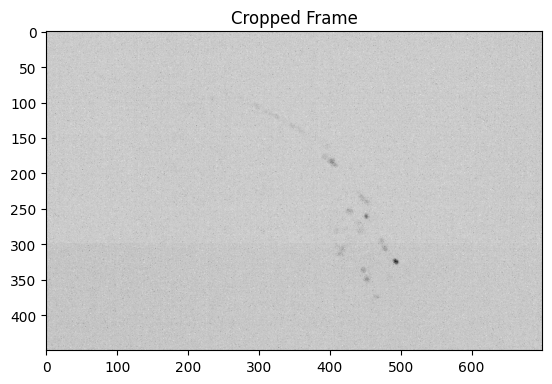

In [7]:
Y_MIN = 0
Y_MAX = 450
X_MIN = 200
X_MAX = 900

cropped_array = dask_array[:, :, Y_MIN:Y_MAX, X_MIN:X_MAX]

# Compute and visualize a cropped frame
cropped_frame = cropped_array[2, 0].compute()

plt.imshow(cropped_frame, cmap='Greys')
plt.title("Cropped Frame")
plt.show()

Calculating intensity profiles...


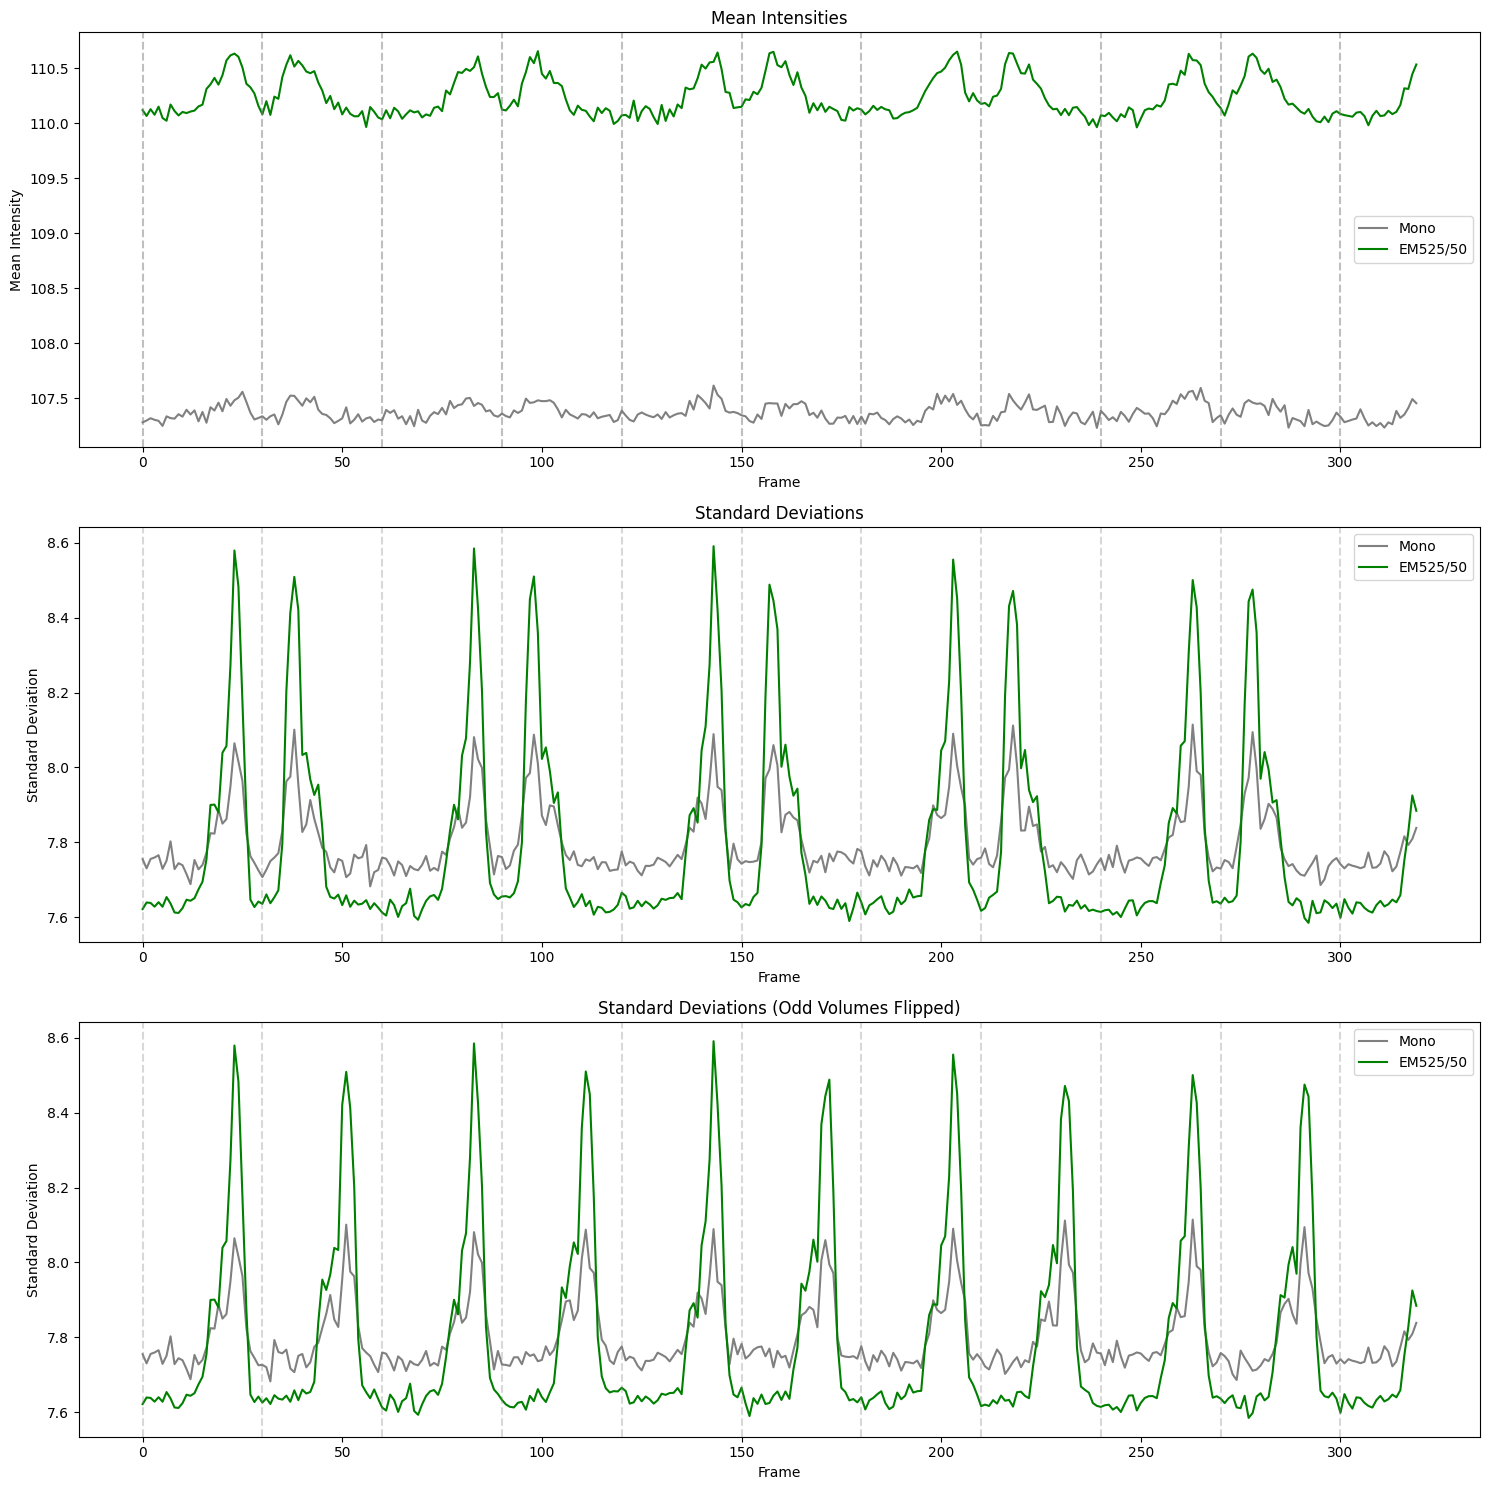

In [49]:
channel_names = ['Mono', 'EM525/50']
channel_colors = ['gray', 'green']

def inspect_raw_data(dask_array, start_frame=0, n_frames=200, fpv=32, y_min=0, y_max=450, x_min=200, x_max=900):
    """
    Inspect raw data before processing, using only a subset of frames.
    
    Args:
        dask_array: Input dask array (F, C, H, W)
        start_frame: Starting frame number
        n_frames: Number of frames to analyze
        fpv: Frames per volume
        y_min, y_max, x_min, x_max: Cropping boundaries
    """
    # Take only the subset we need
    subset = dask_array[start_frame:start_frame + n_frames]
    
    # Crop the array
    cropped = subset[:, :, y_min:y_max, x_min:x_max]
    
    # Calculate mean and std intensities (compute only what we need)
    print("Calculating intensity profiles...")
    mean_intensities = cropped.mean(axis=(2, 3)).compute()
    std_intensities = cropped.std(axis=(2, 3)).compute()
    
    # Create a copy of std_intensities for flipping odd volumes
    flipped_std = std_intensities.copy()
    n_volumes = n_frames // fpv
    
    # Flip odd-numbered volumes
    for vol in range(n_volumes):
        if vol % 2 == 1:  # odd-numbered volume
            start_idx = vol * fpv
            end_idx = start_idx + fpv
            flipped_std[start_idx:end_idx] = flipped_std[start_idx:end_idx][::-1]
    
    # Plot intensity profiles
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))
    
    # Plot mean intensities
    for c in range(cropped.shape[1]):
        ax1.plot(mean_intensities[:, c], label=f'{channel_names[c]}', color=channel_colors[c])
    
    # Add volume boundaries
    for i in range(0, n_frames, fpv):
        ax1.axvline(x=i, color='gray', linestyle='--', alpha=0.5)
    
    ax1.set_title('Mean Intensities')
    ax1.set_xlabel('Frame')
    ax1.set_ylabel('Mean Intensity')
    ax1.legend()
    
    # Plot standard deviations
    for c in range(cropped.shape[1]):
        ax2.plot(std_intensities[:, c], label=f'{channel_names[c]}', color=channel_colors[c])
    
    # Add volume boundaries
    for i in range(0, n_frames, fpv):
        ax2.axvline(x=i, color='gray', linestyle='--', alpha=0.3)
    
    ax2.set_title('Standard Deviations')
    ax2.set_xlabel('Frame')
    ax2.set_ylabel('Standard Deviation')
    ax2.legend()
    
    # Plot standard deviations with odd volumes flipped
    for c in range(cropped.shape[1]):
        ax3.plot(flipped_std[:, c], label=f'{channel_names[c]}', color=channel_colors[c])
    
    # Add volume boundaries
    for i in range(0, n_frames, fpv):
        ax3.axvline(x=i, color='gray', linestyle='--', alpha=0.3)
    
    ax3.set_title('Standard Deviations (Odd Volumes Flipped)')
    ax3.set_xlabel('Frame')
    ax3.set_ylabel('Standard Deviation')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()
    
    return mean_intensities, std_intensities, flipped_std
# def analyze_volume_boundaries(mean_intensities, std_intensities, fpv=40):
#     """
#     Analyze volume boundaries to verify they align with intensity patterns.
    
#     Args:
#         mean_intensities: Computed mean intensities
#         std_intensities: Computed standard deviations
#         fpv: Frames per volume
#     """
#     # Calculate the average pattern over volumes
#     n_volumes = len(mean_intensities) // fpv
#     reshaped_mean = mean_intensities[:n_volumes*fpv].reshape(n_volumes, fpv, -1)
#     avg_pattern = reshaped_mean.mean(axis=0)
    
#     # Plot the average pattern
#     plt.figure(figsize=(12, 6))

#     for c in range(avg_pattern.shape[1]):
#         plt.plot(avg_pattern[:, c], label=f'Channel {channel_names[c]}', color = channel_colors[c])
#     plt.title('Average Intensity Pattern within Volume')
#     plt.xlabel('Frame within Volume')
#     plt.ylabel('Mean Intensity')
#     plt.legend()
#     plt.show()
    
#     # Calculate correlation between consecutive volumes
#     correlations = []
#     for i in range(n_volumes-1):
#         vol1 = mean_intensities[i*fpv:(i+1)*fpv]
#         vol2 = mean_intensities[(i+1)*fpv:(i+2)*fpv]
#         corr = np.corrcoef(vol1.ravel(), vol2.ravel())[0,1]
#         correlations.append(corr)
    
#     plt.figure(figsize=(10, 4))
#     plt.plot(correlations)
#     plt.title('Correlation between Consecutive Volumes')
#     plt.xlabel('Volume Pair')
#     plt.ylabel('Correlation')
#     plt.show()
    
#     return avg_pattern, correlations

# # Example usage:

# Inspect first 200 frames
fpv = 30
start_frame = 10 + fpv
n_frames = 320

# Run initial inspection
_, _, _ = inspect_raw_data(
    dask_array,
    start_frame=start_frame,
    n_frames=n_frames,
    fpv=fpv,
    y_min=0, y_max=450,
    x_min=200, x_max=900
)



In [50]:
def flip_alternate_volumes(dask_array, fpv=30, offset_frames=10):
    """
    Create a new dask array where alternate volumes are flipped, accounting for offset frames
    and ensuring complete volumes.
    
    Args:
        dask_array: Input dask array (F, C, H, W)
        fpv: Frames per volume
        offset_frames: Number of frames to skip at the start to align with volume boundaries
        
    Returns:
        Dask array with alternate volumes flipped, properly aligned to volume boundaries
    """
    import dask.array as da
    import numpy as np
    
    total_frames = dask_array.shape[0]
    
    # Calculate start frame after offset
    start_frame = offset_frames
    
    # Calculate how many complete volumes we can have
    remaining_frames = total_frames - start_frame
    n_complete_volumes = remaining_frames // fpv
    end_frame = start_frame + (n_complete_volumes * fpv)
    
    # Create indices only for the frames we'll keep
    working_frames = end_frame - start_frame
    indices = np.arange(start_frame, end_frame)
    
    # Flip indices for odd-numbered volumes
    for vol in range(n_complete_volumes):
        if vol % 2 == 1:  # odd-numbered volume
            vol_start = start_frame + (vol * fpv)
            vol_end = vol_start + fpv
            indices[vol_start - start_frame:vol_end - start_frame] = \
                indices[vol_start - start_frame:vol_end - start_frame][::-1]
    
    # Use fancy indexing with dask
    return dask_array[indices]

# Example usage:
offset = 10  # Your original offset of 10
fpv = 30     # Frames per volume

flipped_dask_array = flip_alternate_volumes(dask_array, fpv=fpv, offset_frames=offset)

In [8]:
def analyze_intensity_pattern(dask_array, fpv=40):
    """Analyze intensity pattern to verify z-stack structure using Dask arrays"""
    mean_intensities = dask_array.mean(axis=(2, 3)).compute()
    std_intensities = dask_array.std(axis=(2, 3)).compute()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    for c in range(dask_array.shape[1]):
        ax1.plot(mean_intensities[:, c], label=f'Channel {c}')
        ax2.plot(std_intensities[:, c], label=f'Channel {c}')
    
    for i in range(0, dask_array.shape[0], fpv):
        ax1.axvline(x=i, color='gray', linestyle='--', alpha=0.5)
        ax2.axvline(x=i, color='gray', linestyle='--', alpha=0.5)
    
    ax1.set_title('Mean Intensities')
    ax2.set_title('Standard Deviations')
    ax1.legend()
    ax2.legend()
    plt.tight_layout()
    plt.show()
    
    return mean_intensities, std_intensities

def process_array(dask_array, y_min=0, y_max=450, x_min=200, x_max=900,
                 start_idx=0, fpv=40, sig1=0.5, sig2=4):
    """Process Dask array and return filtered array with metadata"""
    
    # Crop the array
    array = dask_array[:, :, y_min:y_max, x_min:x_max]
    
    # Analyze intensity pattern
    print("Analyzing intensity pattern...")
    mean_intensities, std_intensities = analyze_intensity_pattern(array, fpv)
    
    # Set up dimensions
    num_frames = array.shape[0] - start_idx
    T = num_frames // fpv
    C = array.shape[1]
    H = array.shape[2]
    W = array.shape[3]
    D = fpv
    
    print(f"Dimensions: T={T}, C={C}, D={D}, H={H}, W={W}")
    
    # Prepare and reshape array
    extra_frames = num_frames % fpv
    if extra_frames > 0:
        print(f"Removing {extra_frames} extra frames")
        tmp_arr = array[start_idx:-extra_frames].compute()
    else:
        tmp_arr = array[start_idx:].compute()
    
    # Reshape to 5D array (T, C, D, H, W)
    print("Reshaping array...")
    tmp_arr = tmp_arr.reshape(T, D, C, H, W).transpose(0, 2, 1, 3, 4)
    
    # Flip alternate volumes
    print("Flipping alternate volumes...")
    tmp_arr[1::2] = np.flip(tmp_arr[1::2], axis=2)
    aligned_array = tmp_arr
    
    # Apply DoG filter
    print("Applying DoG filter...")
    filtered_array = np.zeros_like(aligned_array, dtype=np.float32)
    
    with tqdm(total=T*C*D, desc="Filtering") as pbar:
        for t in range(T):
            for c in range(C):
                for d in range(D):
                    filtered_array[t, c, d] = gaussian_filter(aligned_array[t, c, d], sig1) - \
                                            gaussian_filter(aligned_array[t, c, d], sig2)
                    pbar.update(1)
    
    # Normalize
    print("Normalizing...")
    filtered_array = (filtered_array - filtered_array.min()) / (filtered_array.max() - filtered_array.min()) * 255
    filtered_array = np.clip(filtered_array, 0, 255).astype(np.int8)
    
    metadata = {
        "C": C, "W": W, "H": H, "D": D, "T": T,
        "original_shape": dask_array.shape
    }
    
    return filtered_array, metadata

def save_to_h5(filtered_array, metadata, output_path, filename):
    """Save processed array to H5 file"""
    os.makedirs(output_path, exist_ok=True)
    h5_path = os.path.join(output_path, f"{filename}.h5")
    
    with h5py.File(h5_path, 'w') as h5:
        for i in range(metadata["T"]):
            dset = h5.create_dataset(f"{i}/frame", 
                                   (metadata["C"], metadata["W"], 
                                    metadata["H"], metadata["D"]), 
                                   dtype="i2", compression="gzip")
            dset[...] = np.transpose(filtered_array[i], (0, 2, 3, 1))
        
        # Metadata
        h5.attrs.update({
            "name": filename,
            **metadata
        })
    
    print(f"Saved to: {h5_path}")
    return h5_path

In [ ]:
# Process the array
filtered_array, metadata = process_array(
    dask_array=dask_array,
    y_min=0, y_max=450,
    x_min=100, x_max=900,
    fpv=40  # Frames per volume
)


Analyzing intensity pattern...


In [1]:
import h5py

# Open the HDF5 file
file_path = '/om2/user/kirjner/WormWork/targettrack/unlabeled_worm_head_example.h5'
with h5py.F# Load the ND2 file
file_path = "/nese/mit/group/boydenlab/Konstantinos/microscopy_data/01082025/01082025 swf702 ya sodium_aside_60slides_per_sec/worm_1nd2003.nd2"
data = nd2.imread(file_path)ile(file_path, 'r') as f:
    # Check if the 'pointdat' dataset exists
    if 'pointdat' in f:
        # Access the 'pointdat' dataset
        pointdat = f['pointdat']
        
        # Print basic information about 'pointdat'
        print("Dataset: 'pointdat'")
        print(f"Shape: {pointdat.shape}")
        print(f"Dtype: {pointdat.dtype}")
        
        # Optionally, preview a subset of data
        print("\nPreview of data (first 5 entries):")
        print(pointdat[:5])
    else:
        print("'pointdat' dataset not found in the file.")

    # List all attributes in the file (optional)
    print("\nFile attributes:")
    for key in f.attrs.keys():
        print(f"{key}: {f.attrs[key]}")

    # List all datasets/groups at the root level
    print("\nMain groups/datasets:")
    for key in f.keys():
        print(key)


Dataset: 'pointdat'
Shape: (3002, 85, 3)
Dtype: float32

Preview of data (first 5 entries):
[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]]

File attributes:
C: 2
D: 16
H: 160
N_neurons: 84
N_points: 84
T: 3002
W: 256
dset_path_from_GUI: /nese/mit/group/boydenlab/Konstantinos/targettrack_data/unlabeled_worm_head_example.h5
name: 184
pixel_scale: [1 1 4]
pointdat: True

Main groups/datasets:
0
1
10
100
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
101
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
102
1020
1021
1022


In [4]:
import h5py

# Open the file
f = h5py.File('/om2/user/kirjner/WormWork/targettrack/unlabeled_worm_head_example.h5', 'r')

# Inspect the structure of datasets
for key in f.keys():
    print(f"Dataset: {key}")
    data = f[key]
    print(f" - Shape: {data.shape}")
    print(f" - Dtype: {data.dtype}")
    print(f" - Attributes: {list(data.attrs.keys())}")

f.close()


Dataset: 0


KeyError: "Unable to open object (object '0' doesn't exist)"